# Style Transfer

<img src="https://i0.wp.com/chelseatroy.com/wp-content/uploads/2018/12/neural_style_transfer.png?resize=768%2C311&ssl=1">

La idea de este trabajo final es reproducir el siguiente paper:

https://arxiv.org/pdf/1508.06576.pdf

El objetivo es transferir el estilo de una imagen dada a otra imagen distinta. 

Como hemos visto en clase, las primeras capas de una red convolucional se activan ante la presencia de ciertos patrones vinculados a detalles muy pequeños.

A medida que avanzamos en las distintas capas de una red neuronal convolucional, los filtros se van activando a medida que detectan patrones de formas cada vez mas complejos.

Lo que propone este paper es asignarle a la activación de las primeras capas de una red neuronal convolucional (por ejemplo VGG19) la definición del estilo y a la activación de las últimas capas de la red neuronal convolucional, la definición del contenido.

La idea de este paper es, a partir de dos imágenes (una que aporte el estilo y otra que aporte el contenido) analizar cómo es la activación de las primeras capas para la imagen que aporta el estilo y cómo es la activación de las últimas capas de la red convolucional para la imagen que aporta el contenido. A partir de esto se intentará sintetizar una imagen que active los filtros de las primeras capas que se activaron con la imagen que aporta el estilo y los filtros de las últimas capas que se activaron con la imagen que aporta el contenido.

A este procedimiento se lo denomina neural style transfer.

# En este trabajo se deberá leer el paper mencionado y en base a ello, entender la implementación que se muestra a continuación y contestar preguntas sobre la misma.

# Una metodología posible es hacer una lectura rápida del paper (aunque esto signifique no entender algunos detalles del mismo) y luego ir analizando el código y respondiendo las preguntas. A medida que se planteen las preguntas, volviendo a leer secciones específicas del paper terminará de entender los detalles que pudieran haber quedado pendientes.

Lo primero que haremos es cargar dos imágenes, una que aporte el estilo y otra que aporte el contenido. A tal fin utilizaremos imágenes disponibles en la web.

In [ ]:

# Imagen para estilo
!wget https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg

# Imagen para contenido
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg

# Creamos el directorio para los archivos de salida
!mkdir /content/output


--2022-02-28 18:15:20--  https://upload.wikimedia.org/wikipedia/commons/5/52/La_noche_estrellada1.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 223725 (218K) [image/jpeg]
Saving to: ‘La_noche_estrellada1.jpg’

La_noche_estrellada 100%[===================>] 218.48K  --.-KB/s    in 0.02s   

2022-02-28 18:15:20 (11.9 MB/s) - ‘La_noche_estrellada1.jpg’ saved [223725/223725]

--2022-02-28 18:15:20--  https://upload.wikimedia.org/wikipedia/commons/thumb/f/f4/Neckarfront_T%C3%BCbingen_Mai_2017.jpg/775px-Neckarfront_T%C3%BCbingen_Mai_2017.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 91.198.174.208, 2620:0:862:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|91.198.174.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 153015 (149K) [ima

In [ ]:
"""from keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from keras.applications import vgg19
from keras import backend as K
from pathlib import Path"""

from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
import numpy as np
from scipy.optimize import fmin_l_bfgs_b
import time
import argparse

from tensorflow.keras.applications import vgg19
from tensorflow.keras import backend as K
from pathlib import Path

import tensorflow as tf
tf.compat.v1.disable_eager_execution()


In [ ]:
# Definimos las imagenes que vamos a utilizar, y el directorio de salida
base_image_path = Path("/content/775px-Neckarfront_Tübingen_Mai_2017.jpg")
#base_image_path = Path("/content/zfmly.jpg")
style_reference_image_path = Path("/content/La_noche_estrellada1.jpg")
#style_reference_image_path = Path("/content/zpicasso.jpg")
result_prefix = Path("/content/output")
iterations = 100
"""
base_image_path = Path("d:/deeplearning/cursada/#tpfinal/Trabajo-Final-CV/content/Neckarfront_Tübingen_Mai_2017.jpg")
style_reference_image_path = Path('d:/deeplearning/cursada/#tpfinal/Trabajo-Final-CV/content/La_noche_estrellada1.jpg')
result_prefix = Path('d:/deeplearning/cursada/#tpfinal/Trabajo-Final-CV/content/output')
iterations = 100
"""

'\nbase_image_path = Path("d:/deeplearning/cursada/#tpfinal/Trabajo-Final-CV/content/Neckarfront_Tübingen_Mai_2017.jpg")\nstyle_reference_image_path = Path(\'d:/deeplearning/cursada/#tpfinal/Trabajo-Final-CV/content/La_noche_estrellada1.jpg\')\nresult_prefix = Path(\'d:/deeplearning/cursada/#tpfinal/Trabajo-Final-CV/content/output\')\niterations = 100\n'

# 1) En base a lo visto en el paper ¿Qué significan los parámetros definidos en la siguiente celda?

Respuesta:


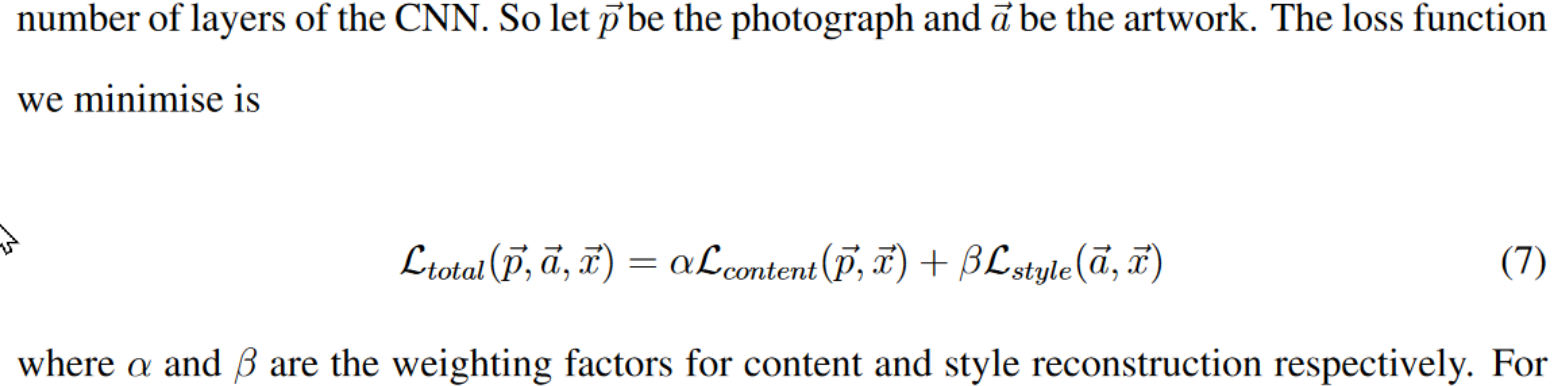


es el alfa (contenido o estructura de la imagen) y beta (estilo) que se usa de la función de loss. Según el peso que se le de a uno u el otro, va a tener más enfasis en estilo o estructura 

In [ ]:
total_variation_weight = 0.1
style_weight = 10
content_weight = 1

In [ ]:
# Definimos el tamaño de las imágenes a utilizar
width, height = load_img(base_image_path).size
img_nrows = 800
img_ncols = int(width * img_nrows / height)

In [ ]:
load_img(base_image_path).size

(1280, 736)

In [ ]:
img_ncols

1391

# 2) Explicar qué hace la siguiente celda. En especial las últimas dos líneas de la función antes del return. ¿Por qué?

Ayuda: https://keras.io/applications/

Respuesta:

La función adecúa al formato para procesarla utilizando la VGG19 de Keras y el tamaño seteado.  
- 1) En primer lugar utiliza una función de Numpy para agregar una dimensión al array,
   
- 2) y en segundo lugar, el pre-procesa de keras, segun lo define el codigo en : https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py    
                            

```
                            will convert the images from RGB to BGR,
                            then will zero-center each color channel with  
                            respect to the ImageNet dataset,  
                            without scaling.
```


Entonces:  
- cambia de RGB a BGR.  
- normaliza la imagen y lo centra para que sea como imagenet utilizando  mean = [103.939, 116.779, 123.68].  


In [ ]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

# 3) Habiendo comprendido lo que hace la celda anterior, explique de manera muy concisa qué hace la siguiente celda. ¿Qué relación tiene con la celda anterior?

Respuesta:

- Convierte de nuevo la imagen a antes de procesarla con la función anterior (preprocess_image), ya que descentra la imagen y la convierte en RGB de BGR. 
Como la imagen habia sido centrada para coincidir con el trianing de imagenet, ahora se agregan los valores medios que habian sido substraidos en el preprocesamiento.




In [ ]:
def deprocess_image(x):
    x = x.reshape((img_nrows, img_ncols, 3))
    # Remove zero-center by mean pixel
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
# get tensor representations of our images
# K.variable convierte un numpy array en un tensor, para 
base_image = K.variable(preprocess_image(base_image_path))
style_reference_image = K.variable(preprocess_image(style_reference_image_path))

In [ ]:
combination_image = K.placeholder((1, img_nrows, img_ncols, 3))

Aclaración:

La siguiente celda sirve para procesar las tres imagenes (contenido, estilo y salida) en un solo batch.

In [ ]:
# combine the 3 images into a single Keras tensor
input_tensor = K.concatenate([base_image,
                              style_reference_image,
                              combination_image], axis=0)

In [ ]:
# build the VGG19 network with our 3 images as input
# the model will be loaded with pre-trained ImageNet weights
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet', include_top=False)
print('Model loaded.')

# get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

Model loaded.


# 4) En la siguientes celdas:

- ¿Qué es la matriz de Gram?¿Para qué se usa?  
Resp: 
Para cada capa de la CNN, se arma una representación de estilo sobre la que se computa la correlación entre los diferentes filtros o features, esta correlación de los features es la matrix de Gram o Graham. Por incluir la correlación de multiples capas, se captura la información de la textura y colores pero no la estructura de la imagen, por eso se realiza el flatten.

- ¿Por qué se permutan las dimensiones de x?  
Primero se permuta para que de bien luego al transponer. Como se observa en el gráfico a continuación, en la matriz de Gram (o Graham), se transpone x para hacer el producto punto.  
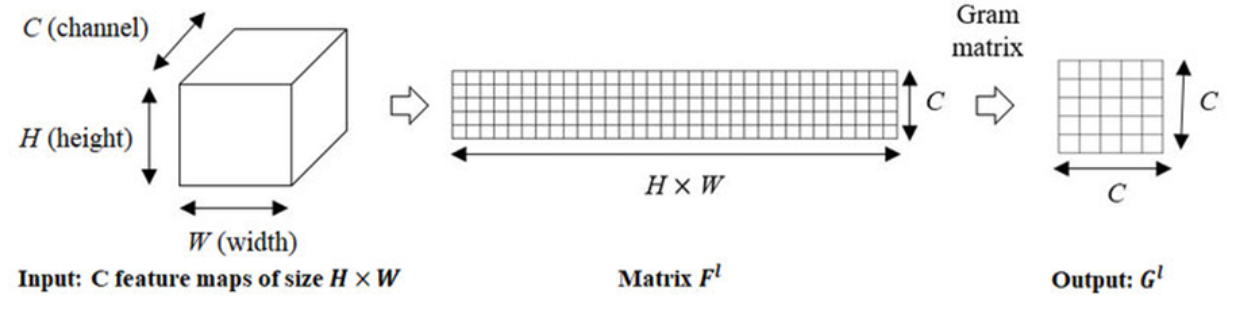
  
Link: https://towardsdatascience.com/neural-networks-intuitions-2-dot-product-gram-matrix-and-neural-style-transfer-5d39653e7916



In [ ]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

# 5) Losses:

Explicar qué mide cada una de las losses en las siguientes tres celdas.

Rta:  
- **Style_loss**: La idea es representar informacion de color y textura según la profundidad de la capa. Es una suma de distancias L2 entre la matriz Gram de la representacion de la imagen que se da como base y la imagen de estilo, extraida de diferentes capas. 

- **Content_loss**: Es la distancia cuadratica media entre la imagen del contenido extraida de una de las ultimas capas y la imagen sintetizada, de manera de luego minimizar las diferencias.  
En el paper esta expresado asi:  
   
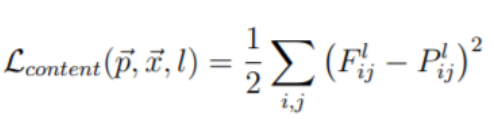
  
donde :  
            *p --> el contenido  
            x --> la imagen sintetizada  
            l --> layer.*    
En el caso de layer, en el codigo iteramos para una lista de layers seleccionados:  
feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
  
- **Total_variation_loss**: Es un término de normalización y suaviza la transición entre pixeles.


In [ ]:
def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style) # style features
    C = gram_matrix(combination) # combination es la imagen sintetizada
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [ ]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))


In [ ]:
def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(
        x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))


In [ ]:
# Armamos la loss total
loss = K.variable(0.0)
layer_features = outputs_dict['block5_conv2'] # elegimos un layer en particular
base_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss = loss + content_weight * content_loss(base_image_features,
                                            combination_features)

feature_layers = ['block1_conv1', 'block2_conv1',
                  'block3_conv1', 'block4_conv1',
                  'block5_conv1']
for layer_name in feature_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :] 
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss = loss + (style_weight / len(feature_layers)) * sl
loss = loss + total_variation_weight * total_variation_loss(combination_image)

In [ ]:
#import tensorflow as tf
#tf.compat.v1.disable_eager_execution()

In [ ]:

grads = K.gradients(loss, combination_image)

In [ ]:
outputs = [loss]
if isinstance(grads, (list, tuple)):
    outputs += grads
else:
    outputs.append(grads)

f_outputs = K.function([combination_image], outputs)

# 6) Explique el propósito de las siguientes tres celdas. ¿Qué hace la función fmin_l_bfgs_b? ¿En qué se diferencia con la implementación del paper? ¿Se puede utilizar alguna alternativa?
  
Respuesta:  
Explique el propósito de las siguientes tres celdas:  
- **eval_loss_and_grads**: Evalua loss y gradiente de la loss de la imagen generada (grads), haciendo reshaping del tensor y usando la funcion de las celdas anteriores (f_outputs)
- **Evaluator**: Se define una clase que sera usada luego. Se encarga de convertir los datos ya que se utiliza posteriormente el optimizador L-BFGS de Scipy, pero el mismo no maneja los datos como Keras.   
- **La tercer celda** es el iterador del evaluador. Se itera 100 veces (definido en la variable iterations al principio).  
En cada iteración se deprocesa la imagen ("descentra", pasa de BGR a RGB) y se guarda la imagen.  

¿Qué hace la función fmin_l_bfgs_b?  
es una función de optimización, que tiene como ventaja, entre otras caracteristicas, que se puede paralelizar.  
  
¿En qué se diferencia con la implementación del paper?  
En el paper se usa las loss de style y content, mientras el ejemplo que estamos viendo además se usa un variation loss.  
  
¿Se puede utilizar alguna alternativa?  
Si, lo habitual hubiera sido con SGD.  




In [ ]:
def eval_loss_and_grads(x):
    x = x.reshape((1, img_nrows, img_ncols, 3))
    outs = f_outputs([x])
    loss_value = outs[0]
    if len(outs[1:]) == 1:
        grad_values = outs[1].flatten().astype('float64')
    else:
        grad_values = np.array(outs[1:]).flatten().astype('float64')
    return loss_value, grad_values

# this Evaluator class makes it possible
# to compute loss and gradients in one pass
# while retrieving them via two separate functions,
# "loss" and "grads". This is done because scipy.optimize
# requires separate functions for loss and gradients,
# but computing them separately would be inefficient.

In [ ]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        loss_value, grad_values = eval_loss_and_grads(x)
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

# 7) Ejecute la siguiente celda y observe las imágenes de salida en cada iteración.

Resp:
Fue ejecutado, pero quedó grabado otro test cuando volvi a re-ejecutar.
Debido a que colab me puso limites de CPU, no pude volver a correrlo nuevamente para la entrega, pero ya habia salvado todas las imagenes en iteraciones.

In [ ]:
evaluator = Evaluator()

# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
x = preprocess_image(base_image_path)

for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(),
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # save current generated image
    img = deprocess_image(x.copy())
    fname = result_prefix / ('output_at_iteration_%d.png' % i)
    save_img(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 372532400000.0
Image saved as /content/output/output_at_iteration_0.png
Iteration 0 completed in 112s
Start of iteration 1
Current loss value: 176868230000.0
Image saved as /content/output/output_at_iteration_1.png
Iteration 1 completed in 92s
Start of iteration 2
Current loss value: 104582050000.0
Image saved as /content/output/output_at_iteration_2.png
Iteration 2 completed in 92s
Start of iteration 3
Current loss value: 70295960000.0
Image saved as /content/output/output_at_iteration_3.png
Iteration 3 completed in 93s
Start of iteration 4
Current loss value: 53308740000.0
Image saved as /content/output/output_at_iteration_4.png
Iteration 4 completed in 93s
Start of iteration 5
Current loss value: 44853404000.0
Image saved as /content/output/output_at_iteration_5.png
Iteration 5 completed in 93s
Start of iteration 6
Current loss value: 38247000000.0
Image saved as /content/output/output_at_iteration_6.png
Iteration 6 completed in 93s
Start of 

# 8) Generar imágenes para distintas combinaciones de pesos de las losses. Explicar las diferencias. (Adjuntar las imágenes generadas como archivos separados.)

Respuesta:
Se probaron diferentes experimentos, de los cuales se especifican los pesos para cada uno y además de muestra el resultado en la iteración 20 para cada experimento. Los archivos completos se encuentran en `/pregunta8/experimento2`, `/pregunta8/experimento3` y `/pregunta8/experimento4`

- **experimento 2:** total_variation_weight = 0.1
style_weight = 1
content_weight = 10
  
  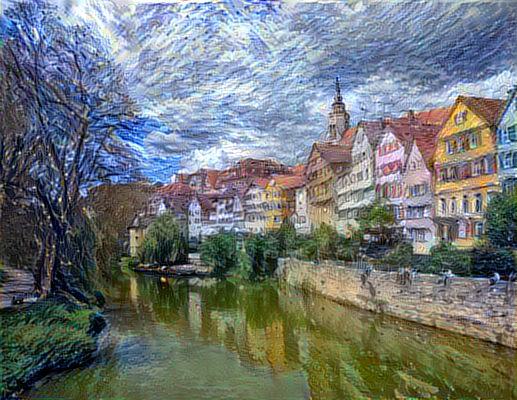

- **experimento 3:** total_variation_weight = 0.1
style_weight = 1000
content_weight = 1
  
  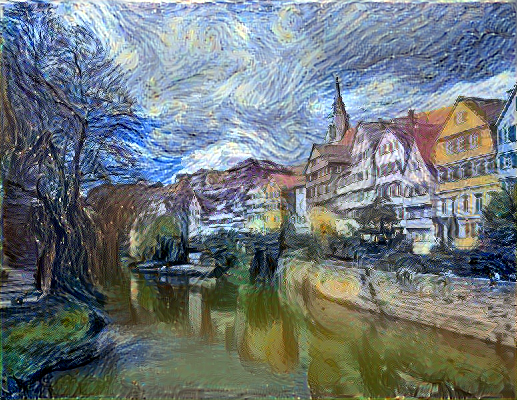

- **experimento 4:** total_variation_weight = 1000
style_weight = 10
content_weight = 1
  
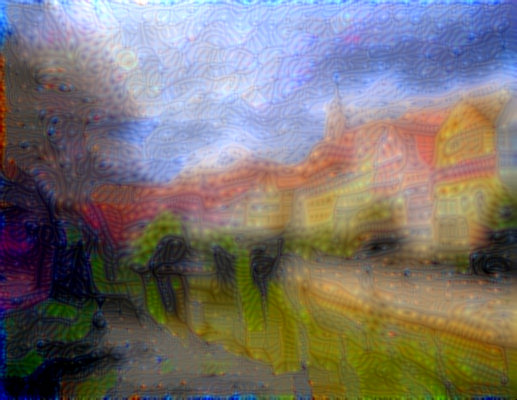


**Resumen:**
Se probó con los pesos originales mientras que en los otros experimentos se fue probando dándole más peso al contenido, y otras a la variación. Se puede observar que con más peso el contenido, se pierden menos detalles de la foto original, cuando se da más peso al estilo se enfatiza la textura y colores del estilo, y finalmente cuando se le da mucho peso a la variación, sube mucho el suavizado que se le da a la imagen sintetizada.

# 9) Cambiar las imágenes de contenido y estilo por unas elegidas por usted. Adjuntar el resultado.

Respuesta:
Se adjunta resultado de ejercicio. La configuración utilizada fue:  
``    total_variation_weight = 0.05``  
``    style_weight = 1000``  
``    content_weight = 1``  
y los detalles, junto con la imagen de contenido y estilo se encuentra en /pregunta9/ del repositorio.  
A continuación se muestra resultado final:    
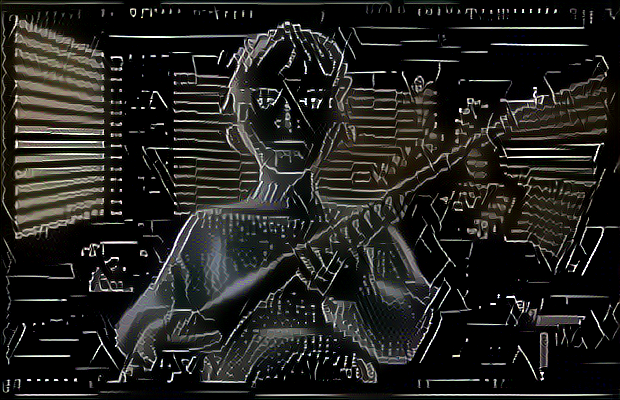